# 4. Unsupervised Learning
# Exploratory data analysis - Preprocessing

## Principal Component Analysis (PCA) for dimensionality reduction and preprocessing

## PCA of the iris dataset

[ ![](iris.png) ](iris.png)

Let’s apply a Principal Component Analysis (PCA) to the iris dataset and then plot the irises across the first three PCA dimensions. This will allow us to better differentiate between the three types.

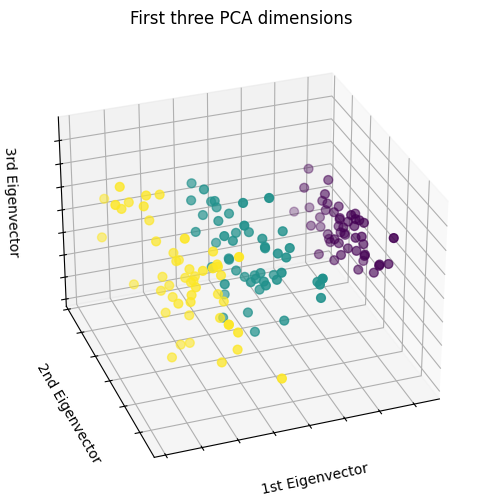

In [52]:
# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401

from sklearn.decomposition import PCA

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

# Fit the model with X and apply the dimensionality reduction on X.
# The input data is centered but not scaled for each feature
X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=iris.target,
    s=40,
)

ax.set_title("First three PCA dimensions")
ax.set_xlabel("1st Eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd Eigenvector")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd Eigenvector")
ax.zaxis.set_ticklabels([])

plt.show()

PCA will create 3 new features that are a linear combination of the 4 original features. In addition, this transform maximizes the variance. With this transformation, we see that we can identify each species using only the first feature (i.e. first eigenvalues).

## Principal Component Analysis of genetic variation


PCA is used in many ways -- as **a dimensionality reduction method, for visualizing data, for understanding the drivers of variability in the data, and for interpreting correlations between the coordinates** (something which we will use here).

\[Novembre J, Johnson T, Bryc K, Kutalik Z, Boyko AR, Auton A, Indap A, King KS, Bergmann S, Nelson MR, Stephens M. Genes mirror geography within Europe. **Nature. 2008** Nov 6;456(7218):98-101.\]

[ ![](nature.png) ](nature.png)
*A statistical summary of genetic data from 1,387 Europeans based on principal component axis one (PC1) and axis two (PC2). Small coloured labels represent individuals and large coloured points represent median PC1 and PC2 values for each country. The inset map provides a key to the labels. The PC axes are rotated to emphasize the similarity to the geographic map of Europe. AL, Albania; AT, Austria; BA, Bosnia-Herzegovina; BE, Belgium; BG, Bulgaria; CH, Switzerland; CY, Cyprus; CZ, Czech Republic; DE, Germany; DK, Denmark; ES, Spain; FI, Finland; FR, France; GB, United Kingdom; GR, Greece; HR, Croatia; HU, Hungary; IE, Ireland; IT, Italy; KS, Kosovo; LV, Latvia; MK, Macedonia; NO, Norway; NL, Netherlands; PL, Poland; PT, Portugal; RO, Romania; RS, Serbia and Montenegro; RU, Russia, Sct, Scotland; SE, Sweden; SI, Slovenia; SK, Slovakia; TR, Turkey; UA, Ukraine; YG, Yugoslavia.*

The data for this problem is a real dataset which comes from the 1000 genomes project. Each of the 995 lines in the file represents an individual. The first three columns represent respectively the individual’s unique identifier, his/her sex (1=male, 2=female) and the population he or she belongs. The subsequent 10101 columns of each line are a subsample of nucleobases from the individual’s genome.

The idea behind PCA is in essence very simple. For a given set of $m$ vectors of the same size (say $n$), or in other words $m$ $n$-dimensional vectors, we are interested in finding $k$ $n$-dimensional vectors where $k\le m$ that "best" represent the original $m$ $n$-dimensional vectors. In other words, when we approximately express each of the $m$ vectors as a linear combination of the $k$ vectors, then this is the "best" possible representation of the vectors. This "best" depends on how we define it. 
 For PCA, **the "best" $k$
 vectors are those that capture the maximum variance of data (the $m$
 vectors)**. This is also mathematically equivalent to saying (duality) that PCA defines the “best-fit line” (one along each of the $k$
 vectors) as the one that minimizes the average squared Euclidean distance between the line and the data points. These top $k$
 "best" vectors are what are called the principal components of the data. The illustration on the right should help identify what the principal component looks like (adopted from Gregory Valiant's notes).
 
In the illustration, the "good" line (the first principal component) is the one for which projection of the data points onto it keeps the two clusters separated, while the projection onto the bad line merges the two clusters. The theory for computing involves eigenvector calculation. We will leave that for sklearn but if you are keen, I would direct you to the notes by Gregory Valiant.

[ ![](pca.png) ](pca.png)

In [55]:
from sklearn.decomposition import PCA
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

#read in a pandas df
def readAndProcessData():
    """
        Function to read the raw text file into a dataframe and keeping the 
        population, gender separate from the genetic data
        
        We also calculate the population mode for each attribute or trait (columns)
        Note that mode is just the most frequently occuring trait
        
        return: dataframe (df), modal traits (modes), population and gender for each individual row
    """
    
    df = pd.read_csv('p4dataset2020.txt', header=None, delim_whitespace=True)
    gender = df[1]
    population = df[2]
    print(np.unique(population))
    
    df.drop(df.columns[[0, 1, 2]],axis=1,inplace=True)
    modes = np.array(df.mode().values[0,:])
    return df, modes, population, gender

df, modes, population, gender = readAndProcessData()

['ACB' 'ASW' 'ESN' 'GWD' 'LWK' 'MSL' 'YRI']


So there are individuals from 7 populations in our data.




#### Preprocessing
To understand what makes some population members special, I would like to focus on the mutations in the genomes rather than the genomes themselves. So I first convert the data from the text file of nucleobases to a real-valued matrix (PCA needs a real-valued matrix). Specifically, convert the genetic data into a binary matrix $X$ such that $X_{i,j}= 0$ if the $i^{th}$ individual has column $j$’s mode nucleobase for his or her $j^{th}$ nucleobase, and $X_{i,j}= 1$ otherwise. Note that in this way, all mutations appear as a 1, even if they are different mutations, so if the mode for column $j$ is “G”, then if individual $i$ has an “A”,“T”, or “C”, then $X_{i,j}= 1$.


In [56]:
def convertDfToMatrix(df, mode):
    """
        Create a binary matrix (binarized) representing mutations away from mode
        Each row is for an individual, and each column is a trait
        
        binarized_{i,j}= 0 if the $i^{th}$ individual has column 
        $j$’s mode nucleobase for his or her $j^{th}$ nucleobase, 
        and binarized_{i,j}= 1 otherwise
    """
    
    raw_np = df.to_numpy()
    binarized = np.where(raw_np!=modes, 1, 0)
    return binarized

X = convertDfToMatrix(df, modes)

# perform PCA

pca = PCA(n_components=3)
pca.fit(X) 

#Data points projected along the first, second and the third PC
projectedPrincipal = np.matmul(X, pca.components_[0])
projectedSecondary = np.matmul(X, pca.components_[1])
projectedTertiary = np.matmul(X, pca.components_[2])

# The dimensions of the returned PCA vectors should be the same as that of
# the original data vectors (the rows corresponding to different individuals). 

assert(X.shape[0] == projectedPrincipal.shape[0])

#### Population Clusters from Mutations Data
Let's examine the first 2 principal components of X. These components contain lots of information about our data set.  We'll create a scatter plot with each of the 995 rows of $X$ projected onto the first two principal components.  In other words, the horizontal axis is PC1, the vertical axis is PC2, and each individual should be projected onto the subspace spanned by PC1 and PC2.


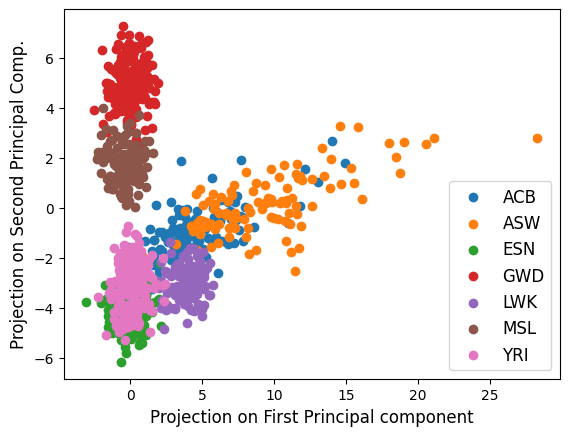

In [57]:
def groupByPop(x, y, classLabels):   
    """
        Function that creates a scatter plot of the projections of the 
        data points onto the first (principal) PC versus their projection
        on the second PC and labels each datapoint according to which of the 
        classes the datapoint belongs to in "classLabels"
        
        args:
            x: Projection on First Principal component for all datapoints
            y: Projection on Second Principal component for all datapoints
            classLabels: population; can be in ['ACB' 'ASW' 'ESN' 'GWD' 'LWK' 'MSL' 'YRI']
                see http://www.1000genomes.org/faq/which-populations-are-part-your-study/
                for details on population info
    """

    classDict = {}
    classes = np.unique(classLabels)
    for label in classes:
        idx = np.where(classLabels == label)
        classDict[label] = (x[idx], y[idx])
    for lab in classes:
        x, y = classDict[lab]
        plt.scatter(x, y, label=lab)
    plt.legend(fontsize=12)
    plt.xlabel('Projection on First Principal component', fontsize=12)
    plt.ylabel('Projection on Second Principal Comp.', fontsize=12)
    plt.savefig('FirstSecond.png', format='png')
    plt.show()

# call the function
groupByPop(projectedPrincipal, projectedSecondary, population)

Population	
African Ancestry in SW USA [ASW]	<br>
African Caribbean in Barbados [ACB]<br>
Esan in Nigeria [ESN]<br>
Gambian in Western Division – Mandinka [GWD]<br>
Luhya in Webuye, Kenya [LWK]<br>
Mende in Sierra Leone [MSL]<br>
Yoruba in Ibadan, Nigeria [YRI]<br>



Population clustering! Notice how different population members have similar values of their projections onto the prncipal components. That means, individuals in a particular population have similar gene mutations such that their data vectors start to look similar! So the correlation between the first and second principal components for members of a population helps cluster the groups! So, it is the first and second PCs that capture varibility in genes due to population differences. Let's keep exploring!

#### Gender Clusters from Mutations Data
This time, let's examine the first and the third principal components of X. We'll create a scatter plot with each of the 995 rows of $X$
 projected onto the first and third principal components this time.

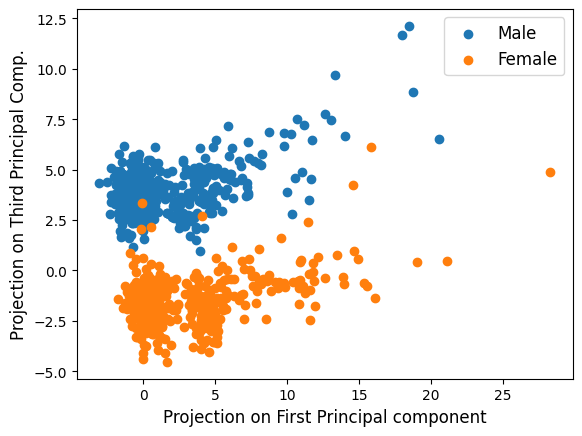

In [60]:
def groupByPop(x, y, classLabels):   
    """
        Function that creates a scatter plot of the projections of the 
        data points onto the first (principal) PC versus their projection
        on the third PC and labels each datapoint according to which of the 
        classes the datapoint belongs to in "classLabels"
        
        args:
            x: Projection on First Principal component for all datapoints
            y: Projection on Third Principal component for all datapoints
            classLabels: her gender specs of population -- `Male` or `Female`
    """
    
    classDict = {}
    classes = np.unique(classLabels)
    for label in classes:
        idx = np.where(classLabels == label)
        classDict[label] = (x[idx], y[idx])
    for label in classes:
        x, y = classDict[label]
        plt.scatter(x, y, label='Male' if label == 1 else 'Female')
    plt.legend(fontsize=12)
    plt.xlabel('Projection on First Principal component', fontsize=12)
    plt.ylabel('Projection on Third Principal Comp.', fontsize=12)
    plt.savefig('FirstThird.png', format='png')
    plt.show()
    
# call the function    
groupByGender(projectedPrincipal, projectedTertiary, gender)

Interestingly enough, gender differences pop out! Note that there is a strong correlation between data members within the male and within the female sections. Also note once again, the first and third PC projections tend to be different from each other for males and females allowing for clustering!

Often PCs are excellent predictors of latitude and longitude -> correct using only linear functions of latitude and longitude to determine the means of our simulated phenotypes. For real phenotypes, higher order functions of PC1 and PC2 and/or additional PCs might be necessary to correct for more complex spatial variation in phenotype. We speculate that at the geographic scale of many association studies carried out so far, many phenotypes are relatively uncorrelated with geography, and that this may explain why in many cases PC-based correction has had little impact in practice. For **phenotypes that are more strongly spatially structured within a sample (for example, height), spurious associations due to population stratification should be more of a concern**.

**when mapping the genetic basis of a disease phenotype, spurious associations can arise if genetic structure is not properly accounted for**

# K-means

The K-Means algorithm clusters data by trying to separate samples in $n$ groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. This algorithm requires the number of clusters to be specified. It scales well to large numbers of samples and has been used across a large range of application areas in many different fields.

The k-means algorithm divides a set of $N$  samples $X$ into $K$ disjoint clusters $C$, each described by the mean $\mu_j$ of the samples in the cluster. The means are commonly called the cluster “centroids”; note that they are not, in general, points from $X$, although they live in the same space.

The K-means algorithm aims to choose centroids that minimise the **inertia**, or **within-cluster sum-of-squares** criterion:

 $\sum_{i=0}^n min_{\mu_j\in C}(\Vert x_i-\mu_j\Vert^2)$
 
Inertia can be recognized as a measure of how internally coherent clusters are. It suffers from various drawbacks:

* Inertia makes the assumption that clusters are convex and isotropic, which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes.

* Inertia is not a normalized metric: we just know that lower values are better and zero is optimal. But in very high-dimensional spaces, Euclidean distances tend to become inflated (this is an instance of the so-called “curse of dimensionality”). Running a dimensionality reduction algorithm such as Principal component analysis (PCA) prior to k-means clustering can alleviate this problem and speed up the computations.


In basic terms, the algorithm has three steps. The first step chooses the initial centroids, with the most basic method being to choose $k$ samples from the dataset $X$. After initialization, K-means consists of looping between the two other steps. The first step assigns each sample to its nearest centroid. The second step creates new centroids by taking the mean value of all of the samples assigned to each previous centroid. The difference between the old and the new centroids are computed and the algorithm repeats these last two steps until this value is less than a threshold. In other words, it repeats until the centroids do not move significantly.

The algorithm can also be understood through the concept of Voronoi diagrams. First the Voronoi diagram of the points is calculated using the current centroids. Each segment in the Voronoi diagram becomes a separate cluster. Secondly, the centroids are updated to the mean of each segment. The algorithm then repeats this until a stopping criterion is fulfilled. Usually, the algorithm stops when the relative decrease in the objective function between iterations is less than the given tolerance value. This is not the case in this implementation: iteration stops when centroids move less than the tolerance.



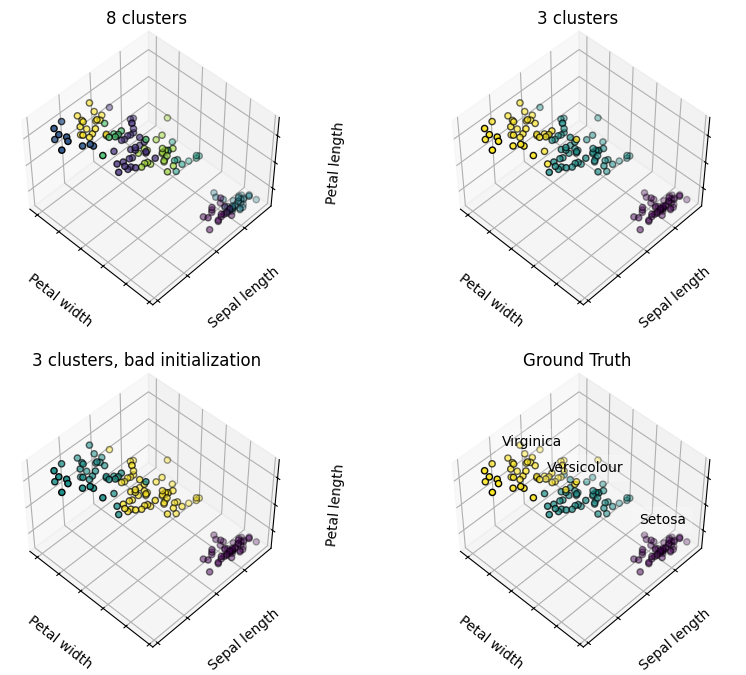

In [6]:
import matplotlib.pyplot as plt

# Though the following import is not directly being used, it is required
# for 3D projection to work with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
import numpy as np

from sklearn import datasets
from sklearn.cluster import KMeans

np.random.seed(5)

iris = datasets.load_iris()
X = iris.data
y = iris.target

estimators = [
    ("k_means_iris_8", KMeans(n_clusters=8)),
    ("k_means_iris_3", KMeans(n_clusters=3)),
    ("k_means_iris_bad_init", KMeans(n_clusters=3, n_init=1, init="random")),
]

fig = plt.figure(figsize=(10, 8))
titles = ["8 clusters", "3 clusters", "3 clusters, bad initialization"]
for idx, ((name, est), title) in enumerate(zip(estimators, titles)):
    ax = fig.add_subplot(2, 2, idx + 1, projection="3d", elev=48, azim=134)
    est.fit(X)
    labels = est.labels_

    ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=labels.astype(float), edgecolor="k")

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_xlabel("Petal width")
    ax.set_ylabel("Sepal length")
    ax.set_zlabel("Petal length")
    ax.set_title(title)

# Plot the ground truth
ax = fig.add_subplot(2, 2, 4, projection="3d", elev=48, azim=134)

for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
    ax.text3D(
        X[y == label, 3].mean(),
        X[y == label, 0].mean(),
        X[y == label, 2].mean() + 2,
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"),
    )

ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y, edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.set_xlabel("Petal width")
ax.set_ylabel("Sepal length")
ax.set_zlabel("Petal length")
ax.set_title("Ground Truth")

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show()

# Hierarchical clustering

Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them successively. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample. See the Wikipedia page for more details.

The AgglomerativeClustering object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. The **linkage criteria** determines the metric used for the merge strategy:

* **Ward** minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.

* **Maximum or complete linkage** minimizes the maximum distance between observations of pairs of clusters.

* **Average linkage** minimizes the average of the distances between all observations of pairs of clusters.

* **Single linkage** minimizes the distance between the closest observations of pairs of clusters.

AgglomerativeClustering can also scale to large number of samples when it is used jointly with a connectivity matrix, but is computationally expensive when no connectivity constraints are added between samples: it considers at each step all the possible merges.

Agglomerative cluster has a “rich get richer” behavior that leads to uneven cluster sizes. In this regard, single linkage is the worst strategy, and Ward gives the most regular sizes. However, the affinity (or distance used in clustering) cannot be varied with Ward, thus for non Euclidean metrics, average linkage is a good alternative. Single linkage, while not robust to noisy data, can be computed very efficiently and can therefore be useful to provide hierarchical clustering of larger datasets. Single linkage can also perform well on non-globular data.



## Varying the metric

Single, average and complete linkage can be used with a variety of distances (or affinities), in particular Euclidean distance (l2), Manhattan distance (or Cityblock, or l1), cosine distance, or any precomputed affinity matrix.

* l1 distance is often good for sparse features, or sparse noise: i.e. many of the features are zero, as in text mining using occurrences of rare words.

* cosine distance is interesting because it is invariant to global scalings of the signal.

The guidelines for choosing a metric is to use one that maximizes the distance between samples in different classes, and minimizes that within each class.

# Clustering performance evaluation

* clustering define separations of the data similar to some ground truth set of classes 
* clustering define separations of the data satisfying some assumption such that members belong to the same class are more similar than members of different classes according to some similarity metric.

## Rand index
Given the knowledge of the ground truth class assignments labels_true and our clustering algorithm assignments of the same samples labels_pred, the (adjusted or unadjusted) Rand index is a function that measures the similarity of the two assignments, ignoring permutations.

The unadjusted Rand index is proportional to the number of sample pairs whose labels are the same in both labels_pred and labels_true, or are different in both.

In [4]:
from sklearn import metrics
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]
metrics.rand_score(labels_true, labels_pred)

0.6666666666666666

The Rand index does not ensure to obtain a value close to 0.0 for a random labelling. The adjusted Rand index corrects for chance and will give such a baseline.

In [5]:
metrics.adjusted_rand_score(labels_true, labels_pred)

0.24242424242424243

The score range is [0, 1] for the unadjusted Rand index and [-0.5, 1] for the adjusted Rand index. The unadjusted Rand index is often close to 1.0 even if the clusterings themselves differ significantly. This can be understood when interpreting the Rand index as the accuracy of element pair labeling resulting from the clusterings: In practice there often is a majority of element pairs that are assigned the different pair label under both the predicted and the ground truth clustering resulting in a high proportion of pair labels that agree, which leads subsequently to a high score.

## Mutual Information based scores
Given the knowledge of the ground truth class assignments labels_true and our clustering algorithm assignments of the same samples labels_pred, the Mutual Information is a function that measures the agreement of the two assignments, ignoring permutations. Two different normalized versions of this measure are available, Normalized Mutual Information (NMI) and Adjusted Mutual Information (AMI). NMI is often used in the literature, while AMI was proposed more recently and is normalized against chance:

## Silhouette Coefficient

If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:

* ${\bf a}$: The mean distance between a sample and all other points in the same class.

* ${\bf b}$: The mean distance between a sample and all other points in the next nearest cluster.

The Silhouette Coefficient $s$ for a single sample is then given as:

$s=\frac{b-a}{max(a,b)}$

* The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.

* The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

In [7]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
X, y = datasets.load_iris(return_X_y=True)
import numpy as np
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=3, random_state=1).fit(X)
labels = kmeans_model.labels_
metrics.silhouette_score(X, labels, metric='euclidean')

0.551191604619592

### Silhouette score on iris data

In [5]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris['data'][:, 1:3]
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


for n_clusters in range(2, 8):
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    y = clusterer.fit_predict(X)

    message = "For n_clusters = {} The average silhouette_score is: {}"
    print(message.format(n_clusters, round(silhouette_score(X, y), 2)))

For n_clusters = 2 The average silhouette_score is: 0.74
For n_clusters = 3 The average silhouette_score is: 0.59
For n_clusters = 4 The average silhouette_score is: 0.56
For n_clusters = 5 The average silhouette_score is: 0.5
For n_clusters = 6 The average silhouette_score is: 0.5
For n_clusters = 7 The average silhouette_score is: 0.51


[![](silhouette.png)](silhouette.png)